In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

import glob

import cv2

import numpy as np

import torch
from torchvision.transforms.functional import normalize
from gfpgan.archs.gfpganv1_arch import GFPGANv1
from gfpgan.archs.gfpganpyramid_arch import GFPGANPyramid
from basicsr.utils import img2tensor, tensor2img

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
gfpgan = GFPGANPyramid(
    out_size=512,
    num_style_feat=512,
    channel_multiplier=1,
    decoder_load_path=None,
    fix_decoder=True,
    num_mlp=8,
    input_is_latent=True,
    different_w=True,
    narrow=1,
    sft_half=False,
    g=8)

# gfpgan = GFPGANv1(
#     out_size=512,
#     num_style_feat=512,
#     channel_multiplier=1,
#     decoder_load_path=None,
#     fix_decoder=True,
#     num_mlp=8,
#     input_is_latent=True,
#     different_w=True,
#     narrow=1,
#     sft_half=True)

In [3]:
gfpgan.eval()

GFPGANPyramid(
  (conv_body_first): ConvLayer(
    (0): EqualConv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0, bias=False)
    (1): FusedLeakyReLU()
  )
  (conv_body_down): ModuleList(
    (0): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        (1): FusedLeakyReLU()
      )
      (conv2): ConvLayer(
        (0): UpFirDnSmooth(upsample_factor=1, downsample_factor=2)
        (1): EqualConv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0, bias=False)
        (2): FusedLeakyReLU()
      )
      (skip): ConvLayer(
        (0): UpFirDnSmooth(upsample_factor=1, downsample_factor=2)
        (1): EqualConv2d(in_channels=16, out_channels=32, kernel_size=1, stride=2, padding=0, bias=False)
      )
    )
    (1): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
 

In [11]:
loadnet = torch.load('/home/viu/Work/GFPGAN/experiments/A100/train_GFPGANv1_512_simple_tub_cx_py_g8_4A100/models/net_g_150000.pth')
# loadnet = torch.load('/home/viu/Work/GFPGAN/gfpgan/weights/GFPGANv1.pth')
if 'params_ema' in loadnet:
    keyname = 'params_ema'
else:
    keyname = 'params'
gfpgan.load_state_dict(loadnet[keyname], strict=True)
gfpgan.eval()
gfpgan = gfpgan.to('cuda:0')

In [12]:
tub_faces = glob.glob('/data/datasets/Turbulence/Tubfaces95/300M/tubimages/*.png')
tub_faces.sort()
len(tub_faces)

267

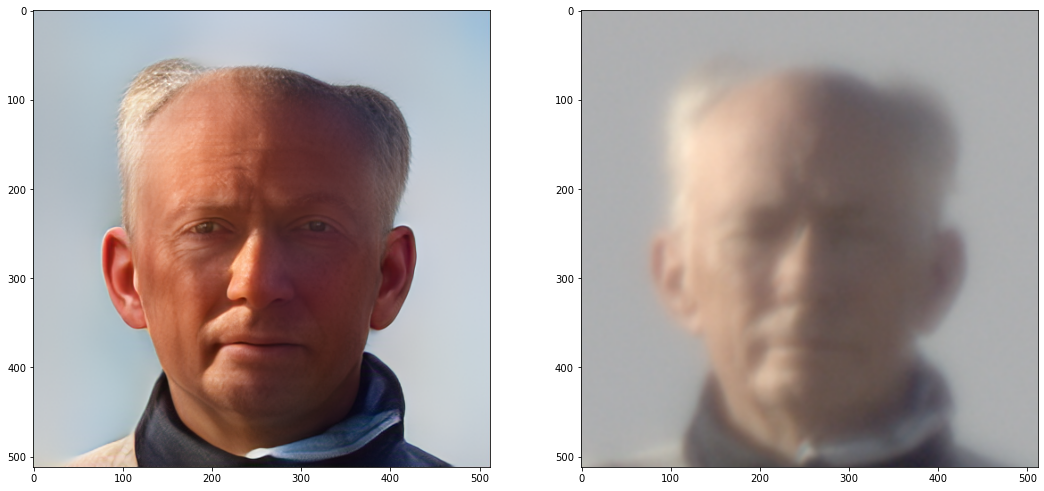

In [13]:
idx = 3
# tub_face4img = cv2.imread('/hdd1/Datasets/Turbulence_data/Victorem_0140__None_PC00C00__R1/001.png', cv2.IMREAD_COLOR)
tub_face_img = cv2.imread(tub_faces[idx], cv2.IMREAD_COLOR)

tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')

with torch.no_grad():
    outputs = gfpgan(tub_face_img_th, return_rgb=False)[0]
    output = torch.mean(outputs, dim=0)
    # output = outputs[7]

plt.figure(figsize=(18, 12))
plt.subplot(1,2,1)
plt.imshow(tensor2img(output, rgb2bgr=False, min_max=(-1, 1)))

plt.subplot(1,2,2)
plt.imshow(tensor2img(tub_face_img_th, rgb2bgr=False, min_max=(-1, 1)))

In [14]:
for tub_face in tqdm(tub_faces):
    tub_face_img = cv2.imread(tub_face, cv2.IMREAD_COLOR)
    # face_helper.clean_all()
    # face_helper.read_image(tub_face_img)
    # face_helper.get_face_landmarks_5(only_center_face=True)
    # face_helper.align_warp_face()
    # if len(face_helper.cropped_faces) < 1:
    #     print(tub_face)
    #     break
    # tub_face_img = face_helper.cropped_faces[0]

    tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
    normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')
    with torch.no_grad():
        outputs = gfpgan(tub_face_img_th, return_rgb=False)[0]
    output = torch.mean(outputs, dim=0)
    # output = gfpgan(tub_face_img_th, return_rgb=False)[0]
    restored_face_img = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1))
 
    restored_face_img_compare = np.concatenate([tub_face_img, restored_face_img], axis=1)
    cv2.imwrite(os.path.join('/data/datasets/Turbulence/Tubfaces95/300M/comparisons/EiGEN_145K/', os.path.basename(tub_face)), restored_face_img)
    # cv2.imwrite(os.path.join('/data/datasets/real_tubface_99/frames/PC00C00_R1_frame_faces', os.path.basename(tub_face)), tub_face_img)


  0%|          | 0/267 [00:00<?, ?it/s]